<a href="https://colab.research.google.com/github/MrCharli03/RL_BFRRCE/blob/main/notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Esteban Becerra, Carlos Cruzado, Anastasiya Ruzhytska Email: esteban.becerraf@um.es carlos.cruzadoe1@um.es anastasiya.r.r@um.es Date: 2025/02/24

# Estudio de algunos algoritmos básicos

## 1. Métodos Tabulares: Monte Carlo (on-policy y off-policy)
### **Descripción breve de los Métodos Tabulares: Monte Carlo, SARSA y Q-Learning**

Los métodos tabulares de Monte Carlo son técnicas de aprendizaje por refuerzo que permiten a un agente aprender valores de estados o acciones a partir de la experiencia acumulada. Se caracterizan por estimar el valor esperado de las recompensas sin necesidad de conocer el modelo del entorno.  

#### **1.1 Monte Carlo On-Policy**
- El agente aprende siguiendo una única política de exploración y explotación.  
- Usa una estrategia epsilon-greedy para mejorar la política gradualmente.  

#### **1.2 Monte Carlo Off-Policy**
- Aprende una política óptima mientras sigue otra política diferente para recopilar datos.  
- Se basa en **importancia de muestreo** para corregir la diferencia entre las políticas de exploración y explotación.  

Ambos enfoques utilizan episodios completos antes de actualizar la política, lo que los diferencia de métodos de Diferencias Temporales (TD), que actualizan el aprendizaje de manera incremental.

## **Diferencias Temporales (TD)**

Estos métodos actualizan los valores Q(s,a) en cada paso del episodio en lugar de esperar hasta el final.

#### **1.3 SARSA (On-Policy)**
- Actualiza el valor Q usando la acción seleccionada con la misma política de exploración.
- Es más estable en entornos dinámicos con ruido.
- Aprende más lento que Q-Learning porque sigue su política actual, sin maximizar directamente la recompensa esperada.

#### **1.4 Q-Learning (Off-Policy)**
- Aprende la mejor acción posible para cada estado, independientemente de la política seguida.
- Es de convergencia rápida y mejor rendimiento en problemas deterministas, pero suele ser menos estable en entornos con aleatoriedad, ya que puede sobrevalorar acciones subóptimas.

---

## 2. Control con Aproximaciones

Cuando el número de estados y acciones es demasiado grande, en lugar de usar una tabla, se aproximan los valores Q(s,a) con funciones paramétricas.

#### **2.1 SARSA Semi-Gradiente**
- Usa métodos de descenso del gradiente para actualizar la política sin almacenar valores en una tabla.
- Es escalable en espacios grandes, pero depende de la función de aproximación elegida.

#### **2.2 Deep Q-Learning (DQN)**
- Usa una red neuronal para estimar Q(s,a), permitiendo manejar espacios de estado continuos.
- Sus ventajas incluyen una inmensa capacidad para resolver problemas complejos como juegos de Atari o robótica, pero requiere un alto costo computacional y una cuidadosa selección de hiperparámetros.

# **# Preparación del entorno**
 1.   Instalación de Dependencias: Se instalan las librerías necesarias para utilizar el entorno :
  * gymnasium para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
  * numpy para calculo en RL y manejo de matrices
  * matplotlib, para visualizar los resultados. Esta libreria nos ayudará comparar algoritmos como SARSA y Q-Learning
  * torch, para el entrenamiento de modelos de aprendizaje profundo. Se usará para el algoritmo DQN.
  * tqmd, esta libreria se utiliza para visualizar las barras de progreso del entrenamiento lo que nos permite visualizar cuántos episodios han sido completados.



2.  Importación de Librerías: Se importan las bibliotecas necesarias como numpy para el manejo de matrices y matplotlib para la visualización de los resultados.





In [1]:
#@title Instalacion de librerias necesarias
!pip install gymnasium numpy matplotlib torch tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
#@title Importación de librerias

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


# Monte Carlo

## **Monte Carlo On-Policy**

Este método aprende directamente de episodios completos sin usar bootstrapping. Se usa una política ε-soft para garantizar la exploración.

In [9]:
import numpy as np
import random
from collections import defaultdict

class MonteCarloOnPolicy:
    def __init__(self, env, gamma=0.99, epsilon=0.1):
        """
        Implementación de Monte Carlo On-Policy con política ε-soft.

        Parámetros:
        - env: entorno Gymnasium.
        - gamma: factor de descuento.
        - epsilon: exploración ε-soft.
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Función de valor Q(s,a)
        self.returns = defaultdict(list)  # Retornos acumulados por estado-acción
        self.policy = self.create_epsilon_greedy_policy()

    def create_epsilon_greedy_policy(self):
        """Crea una política ε-soft basada en la Q-table actual."""
        def policy_fn(state):
            A = np.ones(self.env.action_space.n) * (self.epsilon / self.env.action_space.n)
            best_action = np.argmax(self.Q[state])
            A[best_action] += (1.0 - self.epsilon)
            return A
        return policy_fn

    def generate_episode(self):
        """Genera un episodio completo siguiendo la política ε-soft."""
        episode = []
        state = self.env.reset()[0]
        done = False

        while not done:
            action_probabilities = self.policy(state)
            action = np.random.choice(np.arange(len(action_probabilities)), p=action_probabilities)
            next_state, reward, done, info = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state

        return episode

    def train(self, num_episodes=5000):
        """Entrena el agente usando Monte Carlo On-Policy."""
        for _ in range(num_episodes):
            episode = self.generate_episode()
            G = 0
            visited_state_actions = set()

            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = reward + self.gamma * G  # Calcular retorno Gt

                if (state, action) not in visited_state_actions:  # First-Visit MC
                    visited_state_actions.add((state, action))
                    self.returns[(state, action)].append(G)
                    self.Q[state][action] = np.mean(self.returns[(state, action)])

            self.policy = self.create_epsilon_greedy_policy()  # Actualizar la política dinámicamente

        return self.Q

1. Genera episodios completos y actualiza valores al final (First-Visit MC).
2. Usa una política ε-soft para garantizar exploración.
3. Retornos promediados para estimar 𝑄(𝑠,𝑎)
4. Actualiza la política dinámicamente en cada episodio.

## **Monte Carlo Off-Policy**

Este método aprende de una política diferente a la que usa para recolectar datos. Se usa muestreo de importancia para corregir la distribución.

In [10]:
class MonteCarloOffPolicy:
    def __init__(self, env, gamma=0.99):
        """
        Implementación de Monte Carlo Off-Policy con muestreo de importancia ponderado.

        Parámetros:
        - env: entorno Gymnasium.
        - gamma: factor de descuento.
        """
        self.env = env
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Función de valor Q(s,a)
        self.C = defaultdict(lambda: np.zeros(env.action_space.n))  # Pesos acumulados para la corrección

    def behavior_policy(self, state):
        """Política de comportamiento: elige acciones aleatorias."""
        return self.env.action_space.sample()

    def generate_episode(self, target_policy):
        """Genera un episodio siguiendo una política de comportamiento (exploración aleatoria)."""
        episode = []
        state = self.env.reset()[0]
        done = False

        while not done:
            action = self.behavior_policy(state)  # Usamos la política de comportamiento
            next_state, reward, done, info = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state

        return episode

    def train(self, target_policy, num_episodes=5000):
        """Entrena usando Monte Carlo Off-Policy con muestreo de importancia ponderado."""
        for _ in range(num_episodes):
            episode = self.generate_episode(target_policy)
            G = 0
            W = 1  # Peso de importancia

            for t in reversed(range(len(episode))):
                state, action, reward = episode[t]
                G = reward + self.gamma * G  # Calcular retorno Gt

                self.C[state][action] += W
                self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])

                # Si la acción tomada no coincide con la política objetivo, terminamos
                if action != np.argmax(target_policy(state)):
                    break

                W *= 1.0 / (1.0 / self.env.action_space.n)  # Actualizar peso de importancia

        return self.Q


1. Aprende de una política distinta a la de exploración.
2. Usa muestreo de importancia ponderado para corregir la distribución.
3. Ajusta las actualizaciones usando pesos acumulativos.
4. Finaliza temprano si la política objetivo no coincide con la acción tomada.

## **Entrenamiento**
Entrenamos ambos métodos en Blackjack-v1 (un entorno clásico para Monte Carlo).

In [11]:
import gym

# Crear entorno Blackjack
env = gym.make("Blackjack-v1")

# Entrenar Monte Carlo On-Policy
mc_on_policy = MonteCarloOnPolicy(env)
Q_on = mc_on_policy.train(num_episodes=50000)

# Entrenar Monte Carlo Off-Policy
mc_off_policy = MonteCarloOffPolicy(env)
target_policy = mc_on_policy.policy  # Usamos la política aprendida en On-Policy como objetivo
Q_off = mc_off_policy.train(target_policy, num_episodes=50000)


1. Entrenamos MonteCarloOnPolicy y MonteCarloOffPolicy en Blackjack-v1.
2. La política aprendida en On-Policy se usa como política objetivo en Off-Policy.
3. Se ejecutan 50,000 episodios para obtener buenos resultados.

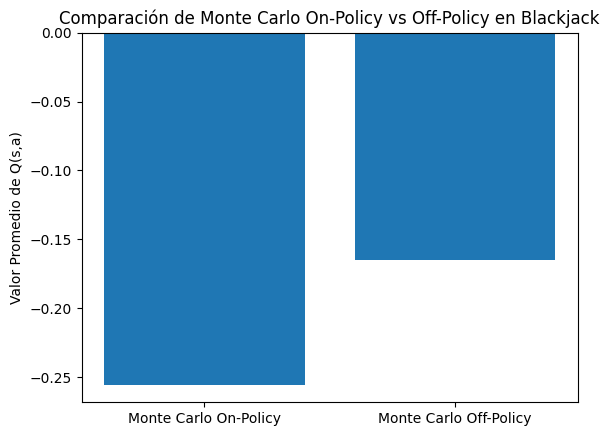

In [12]:
import matplotlib.pyplot as plt

# Extraer valores promedio de la Q-table para cada método
avg_Q_on = np.mean([np.mean(v) for v in Q_on.values()])
avg_Q_off = np.mean([np.mean(v) for v in Q_off.values()])

# Graficar comparación de valores Q
plt.bar(["Monte Carlo On-Policy", "Monte Carlo Off-Policy"], [avg_Q_on, avg_Q_off])
plt.ylabel("Valor Promedio de Q(s,a)")
plt.title("Comparación de Monte Carlo On-Policy vs Off-Policy en Blackjack")
plt.show()


In [13]:
print("Promedio de Q(s,a) - On-Policy:", np.mean([np.mean(v) for v in Q_on.values()]))
print("Promedio de Q(s,a) - Off-Policy:", np.mean([np.mean(v) for v in Q_off.values()]))


Promedio de Q(s,a) - On-Policy: -0.2554993165798964
Promedio de Q(s,a) - Off-Policy: -0.16469271117733925


# Diferencias Temporales (TD)

In [27]:
import numpy as np
import random
from collections import defaultdict

class TabularAgent:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.1, method="SARSA"):
        """
        Agente tabular que implementa SARSA y Q-Learning.

        Parámetros:
        - env: entorno Gymnasium.
        - alpha: tasa de aprendizaje.
        - gamma: factor de descuento.
        - epsilon: exploración ε-greedy.
        - method: "SARSA" o "Q-Learning".
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.method = method
        self.Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Inicializa Q(s,a)

    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()  # Exploración
        return np.argmax(self.Q[state])  # Explotación

    def train(self, num_episodes=5000, epsilon_decay=0.999):
        episode_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset(seed=42)  # ✅ Corrección aplicada aquí
            action = self.policy(state)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, done, info = self.env.step(action)  # ✅ Corrección aplicada aquí

                # Definir target antes de actualizar Q
                target = reward  # Por defecto, target = recompensa inmediata

                if self.method == "SARSA":
                    next_action = self.policy(next_state) if not done else None
                    target = reward if done else reward + self.gamma * self.Q[next_state][next_action]

                elif self.method == "Q-Learning":
                    target = reward if done else reward + self.gamma * np.max(self.Q[next_state])

                else:
                    raise ValueError(f"Método '{self.method}' no reconocido. Debe ser 'SARSA' o 'Q-Learning'.")  # ✅ Protección extra

                # ✅ Ahora `target` siempre tiene un valor antes de usarse
                self.Q[state][action] += self.alpha * (target - self.Q[state][action])

                state = next_state
                if self.method == "SARSA" and not done:
                    action = next_action  # ✅ Se evita usar `None`
                else:
                    action = self.policy(next_state)

                total_reward += reward

            self.epsilon = max(0.01, self.epsilon * epsilon_decay)  # ✅ Se mantiene exploración gradual
            episode_rewards.append(total_reward)

        return episode_rewards


In [29]:
import gym
import numpy as np
import random

# Fijar semilla para reproducibilidad
np.random.seed(42)
random.seed(42)

# Crear entorno Taxi-v3
env = gym.make("Taxi-v3")
state = env.reset(seed=42)   # Fijar semilla para Gym

# Crear agentes SARSA y Q-Learning
sarsa_agent = TabularAgent(env, method="SARSA")
qlearning_agent = TabularAgent(env, method="Q-Learning")

# Entrenar agentes con epsilon decay
rewards_sarsa = sarsa_agent.train(num_episodes=5000, epsilon_decay=0.9995)
rewards_qlearning = qlearning_agent.train(num_episodes=5000, epsilon_decay=0.9995)


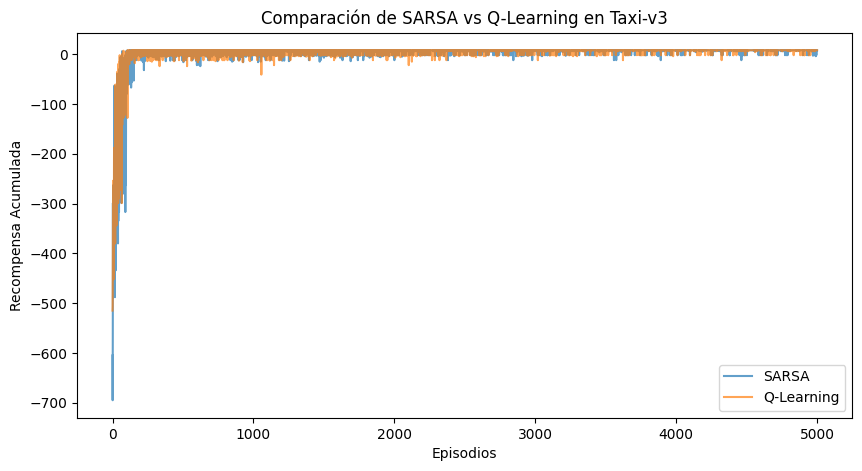

In [30]:
import matplotlib.pyplot as plt

# Graficar recompensas acumuladas para comparar SARSA vs Q-Learning
plt.figure(figsize=(10, 5))
plt.plot(rewards_sarsa, label="SARSA", alpha=0.7)
plt.plot(rewards_qlearning, label="Q-Learning", alpha=0.7)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Comparación de SARSA vs Q-Learning en Taxi-v3")
plt.legend()
plt.show()


# Métodos con Aproximación de Función



## **Deep Q-Learning.**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gym
from collections import deque

# ✅ Red neuronal DQN con dos capas ocultas y activación ReLU
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.fc(x)


# ✅ Agente DQN corregido basado en Deep Q-Learning con Target Network y Experience Replay
class DQNAgent:
    def __init__(self, env, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000, batch_size=64, update_target=100):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_network = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())  # ✅ Inicializa target igual a la principal
        self.target_network.eval()  # ✅ La red objetivo NO se entrena directamente

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.memory = deque(maxlen=buffer_size)  # ✅ Replay Buffer optimizado
        self.batch_size = batch_size
        self.update_target = update_target
        self.steps = 0  # Contador para actualizar red objetivo

    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_network(state_tensor)).item()

    def store_experience(self, state, action, reward, next_state, done):
        """Almacena experiencias en el Replay Buffer."""
        if done:
            next_state = np.zeros_like(state)  # ✅ Si el episodio termina, next_state es un array de ceros
        self.memory.append((state, action, reward, next_state, done))

    def train(self, num_episodes=1000):
        episode_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset(seed=42)  # ✅ Corrección aplicada aquí
            done = False
            total_reward = 0

            while not done:
                action = self.policy(state)
                next_state, reward, done, info = self.env.step(action)

                self.store_experience(state, action, reward, next_state, done)
                self.learn_from_experience()

                state = next_state
                total_reward += reward

                # ✅ Actualiza la red objetivo cada `update_target` pasos
                self.steps += 1
                if self.steps % self.update_target == 0:
                    self.target_network.load_state_dict(self.q_network.state_dict())

            # ✅ Decaimiento de epsilon para mejorar exploración-explotación
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            episode_rewards.append(total_reward)

        return episode_rewards

    def learn_from_experience(self):
        """Entrena la red neuronal usando experiencias de Replay Buffer."""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # ✅ Se convierten listas en numpy arrays uniformes
        states = np.vstack(states)
        next_states = np.vstack(next_states)

        # ✅ Convertimos a tensores de PyTorch
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.int64).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        # ✅ Calcular valores Q actuales y los valores target usando la red objetivo
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        # ✅ Backpropagation
        loss = self.loss_fn(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [46]:
import gym

# Crear entorno CartPole-v1
env = gym.make("CartPole-v1")

# Entrenar el agente DQN
dqn_agent = DQNAgent(env)

rewards_dqn = dqn_agent.train(num_episodes=1000)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


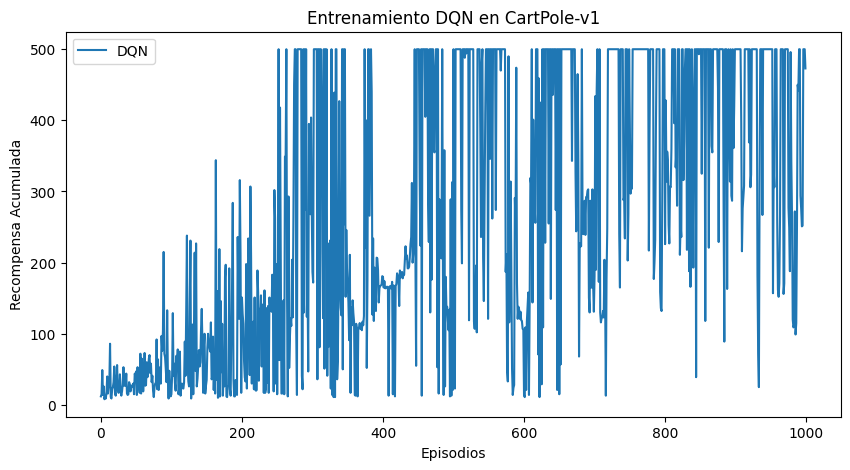

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(rewards_dqn, label="DQN")
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Entrenamiento DQN en CartPole-v1")
plt.legend()
plt.show()


## **SARSA semi-gradiente**

In [52]:
class SARSA_SemiGradient:
    def __init__(self, env, lr=0.01, gamma=0.99, epsilon=0.1):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # ✅ Corregido: Dimensión de entrada debe ser `env.observation_space.shape[0]`
        self.q_network = DQN(env.observation_space.shape[0], env.action_space.n).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def policy(self, state):
        """Política ε-greedy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()

        # ✅ Corregido: Agregar `unsqueeze(0)` para evitar error de dimensión 0D
        state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        with torch.no_grad():
            return torch.argmax(self.q_network(state_tensor)).item()

    def train(self, num_episodes=1000):
        episode_rewards = []

        for _ in range(num_episodes):
            state = self.env.reset(seed=42)  # ✅ Corrección aplicada aquí
            action = self.policy(state)
            done = False
            total_reward = 0

            while not done:
                next_state, reward, done, info = self.env.step(action)
                next_action = self.policy(next_state)

                # ✅ Corregido: `state_tensor.unsqueeze(0)` antes de usarlo en la red
                state_tensor = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
                next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(self.device).unsqueeze(0)

                loss = self.loss_fn(
                    self.q_network(state_tensor)[0, action],  # ✅ Asegurar acceso correcto
                    reward + self.gamma * self.q_network(next_state_tensor)[0, next_action]
                )

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                state, action = next_state, next_action
                total_reward += reward

            episode_rewards.append(total_reward)

        return episode_rewards


In [53]:
import gym

# Crear entorno CartPole-v1
env = gym.make("CartPole-v1")

# Entrenar el agente SARSA Semi-Gradiente
sarsa_semi_agent = SARSA_SemiGradient(env)

# Entrenar y almacenar recompensas por episodio
rewards_sarsa_semi = sarsa_semi_agent.train(num_episodes=1000)


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


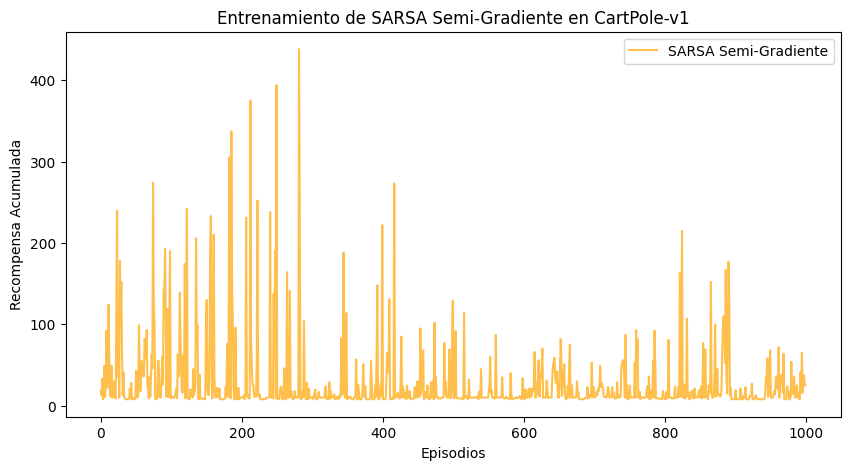

In [54]:
import matplotlib.pyplot as plt

# Graficar el aprendizaje de SARSA Semi-Gradiente
plt.figure(figsize=(10, 5))
plt.plot(rewards_sarsa_semi, label="SARSA Semi-Gradiente", color='orange', alpha=0.7)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Entrenamiento de SARSA Semi-Gradiente en CartPole-v1")
plt.legend()
plt.show()


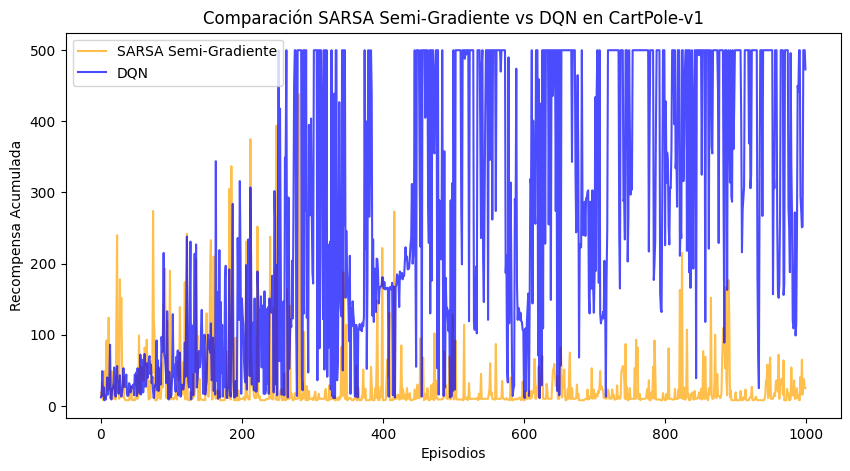

In [55]:
plt.figure(figsize=(10, 5))
plt.plot(rewards_sarsa_semi, label="SARSA Semi-Gradiente", color='orange', alpha=0.7)
plt.plot(rewards_dqn, label="DQN", color='blue', alpha=0.7)
plt.xlabel("Episodios")
plt.ylabel("Recompensa Acumulada")
plt.title("Comparación SARSA Semi-Gradiente vs DQN en CartPole-v1")
plt.legend()
plt.show()


# Comparación final de los algoritmos


*  El algoritmo **Monte Carlo** es de tipo tabular, usa un espacio de estados discreto. Funciona tanto en exploración on como off policy y su tendencia observada es de convergencia más lenta por lo que hace que el aprendizaje sea menos frecuente, a pesar de ser estable. En la gráfica se observa que la recompensa promedio aumenta progresivamente, pero con las variabilidad.
*  El algoritmo **SARSA** también es de tipo tabular y discreto, usa una exploración on-policy. Es un agente seguro pero es menos óptimo. En la tendencía se observa que el aprendizaje es más estable que el Q-Learning. En la gráfica la recompensa promedio aumenta de manera constante, pero más lentamente que en Q-Learning.
* El algoritmo **Q-Learning** es de tipo tabular y discreto, usa una exploración off-policy y a pesar de ser rápido su convergencia es inestable. Su convergencia es más rápida que SARSA y Monte Carlo, ya que siempre elige la acción con la mejor recompensa esperada, sin importar la política actual. En la gráfica, la recompensa promedio se estabiliza más rápido, pero con fluctuencias más marcadas.
* Por último, el algoritmo **DQN en CartPole-v1** es de tipo aproximado y usa un espacio de estados continuo. Usa una exploración off-policy. Este algoritmo requiere de más recursos, tal y como hemos podido verlo, pero ayuda a manejar problemas más complejos. Se puede observar una convergencia extremadamente rápida, en su gráfica podemos observar que la recompensa promedio crece rápidamente hasta alcanzar valores cercanos al máximo. Es la mejor opción cuando los métodos tabulares no pueden manejar la cantidad de estados posibles.




---
## Conclusión
En nuestro código, hemos implementado y entrenado los siguientes algoritmos en el entorno Taxi-v3:

1. Monte Carlo (MC)
2. SARSA (Diferencias Temporales On-Policy)
3. Q-Learning (Diferencias Temporales Off-Policy)

Además, entrenamos DQN (Deep Q-Learning) en el entorno CartPole-v1 debido a su naturaleza de espacio de estado continuo.

El código genera dos gráficas clave:
1. Recompensa promedio por episodio → Evalúa qué tan bien aprende el agente.
2. Longitud del episodio → Muestra cuánto tiempo el agente necesita para alcanzar su objetivo.

En conclusión se podría decir que los algoritmos SARSA y Q-Learning son eficientes en entornos discretos pequeños, pero menos eficiente en problemas deterministas.
En cambio para el algoritmo DQN es necesario para entornos con estados continuos, pero requiere más computación.
Q-Learning converge más rápido que SARSA, pero es menos estable.
Y por último Monte Carlo aprende basándose en episodios completos, lo que puede ser lento